In [113]:
#%pip install --upgrade DiadFit
#%pip install Thermobar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DiadFit as pf
import Thermobar as pt
import os
import matplotlib.gridspec as gridspec

## to make sure paths function regardless of OS
if os.name=='posix':
    slash='/'
else:
    slash='\\'

In [114]:
df_combo=pd.read_excel('Raman_SEM_Merged_mod.xlsx')
df_combo=df_combo.loc[df_combo['Fo']>0].reset_index(drop=True)
len(df_combo)
df_combo.to_clipboard(excel=True)

## Lets load over the XH2O correction
- This is from DeVitre and Wieser (2024) GPL

In [115]:
import pickle
# This is the lowest XH2O
with open('Pf.pkl', 'rb') as f:
    Pf_low = pickle.load(f)

# This is the median XH2O
with open('Pf3.pkl', 'rb') as f:
    Pf_max = pickle.load(f)

# This is the median XH2O - pressure  relationship. 
with open('Pf4.pkl', 'rb') as f:
    Pf_med = pickle.load(f)

# And its defined as XH2O_av=1-Pf_med(P_SW96['P_MPa'])

## Lets load over the Temp vs Fo correction
- Also from DeVitre and Wieser (2024)

In [116]:
with open('TempFoModel.pkl', 'rb') as f:
    Pf_TempFo = pickle.load(f)

In [117]:
SO2_frac=pf.calculate_mole_fraction_2comp(peak_area_a=df_combo['Peak_Area_SO2'], peak_area_b=df_combo['Diad1_Voigt_Area']+df_combo['Diad2_Voigt_Area'],
                                  cross_section_a=5.3, cross_section_b=1.4+0.89, instrument_eff_a=1, instrument_eff_b=1)['% A']

## temp 

In [118]:

df_combo['Temp_from_Fo_all']=Pf_TempFo(df_combo['Fo'])
MeanT=np.nanmean(df_combo['Temp_from_Fo_all'])
df_combo['Temp_from_Fo_all'] = df_combo['Temp_from_Fo_all'].fillna(MeanT)

# Create 'Temp_error' column based on whether 'Temp_from_Fo' is a number
df_combo['Temp_error'] = np.where(df_combo['Temp_from_Fo_all'] == MeanT, 100, 50)


In [119]:
np.nanstd(df_combo['Temp_from_Fo_all'])

36.79809381905391

## Pure CO2 pressure

In [120]:
P_SW96=pf.calculate_P_for_rho_T(CO2_dens_gcm3=df_combo['Density g/cm3'], 
                                T_K=df_combo['Temp_from_Fo_all']+273.15, EOS='SW96')
P_SW96.head()

,P_kbar,P_MPa,T_K,CO2_dens_gcm3
0,0.144386,14.438553,1513.193250,0.048859
1,0.169413,16.941292,1537.338539,0.056119
2,0.393081,39.308146,1510.998480,0.125982
3,0.259715,25.971509,1510.998480,0.085747
4,0.406250,40.625050,1513.129226,0.129648


In [121]:
## Lets calculate XH2O from Kil
XH2O_av=1-Pf_med(P_SW96['P_MPa'])
XH2O_av[XH2O_av<0]=0.02

XH2O_min=1-Pf_low(P_SW96['P_MPa'])
XH2O_min[XH2O_min<0]=0.02

XH2O_max=1-Pf_max(P_SW96['P_MPa'])
XH2O_max[XH2O_max<0]=0.02

df_combo['XH2O']=XH2O_av
df_combo['XH2O']=df_combo['XH2O'].fillna(0)

## CAlculate DZ EOS using the XH2O calc above 

In [122]:
P_DZ06=pf.calculate_entrapment_P_XH2O(XH2O=XH2O_av, CO2_dens_gcm3=df_combo['Density g/cm3'],
                 T_K=df_combo['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)
P_DZ06_MinXH2O=pf.calculate_entrapment_P_XH2O(XH2O=XH2O_min, CO2_dens_gcm3=df_combo['Density g/cm3'],
                 T_K=df_combo['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)
P_DZ06_MaxXH2O=pf.calculate_entrapment_P_XH2O(XH2O=XH2O_max, CO2_dens_gcm3=df_combo['Density g/cm3'],
                 T_K=df_combo['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)

In [123]:
# Now lets do one more iteration - multiple ones really dont change much. 
XH2O_av2=1-Pf_med(100*P_DZ06['P_kbar_mixCO2_DZ06_no_Hloss'])
XH2O_av2[XH2O_av2<0]=0.02

XH2O_min2=1-Pf_low(100*P_DZ06_MinXH2O['P_kbar_mixCO2_DZ06_no_Hloss'])
XH2O_min2[XH2O_min2<0]=0.02

XH2O_max2=1-Pf_max(100*P_DZ06_MaxXH2O['P_kbar_mixCO2_DZ06_no_Hloss'])
XH2O_max2[XH2O_max2<0]=0.02

P_DZ062=pf.calculate_entrapment_P_XH2O(XH2O=XH2O_av2, CO2_dens_gcm3=df_combo['Density g/cm3'],
                 T_K=df_combo['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)
P_DZ06_MinXH2O2=pf.calculate_entrapment_P_XH2O(XH2O=XH2O_min2, CO2_dens_gcm3=df_combo['Density g/cm3'],
                 T_K=df_combo['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)
P_DZ06_MaxXH2O2=pf.calculate_entrapment_P_XH2O(XH2O=XH2O_max2, CO2_dens_gcm3=df_combo['Density g/cm3'],
                 T_K=df_combo['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)


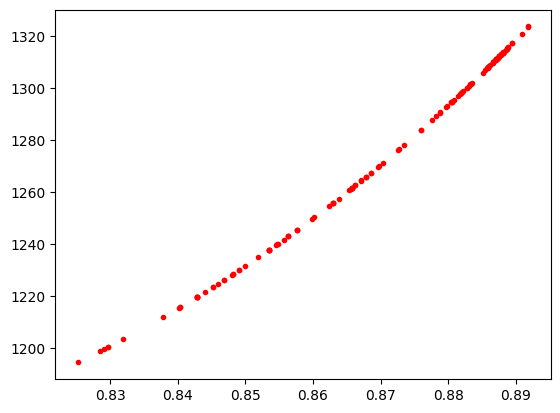

In [124]:
plt.plot(df_combo['Fo'], df_combo['Temp_from_Fo_all'], '.r')

## Lets propagate uncertainty

In [125]:
## Duan and Zhang Error propagate. 
MC_Av_rho_T_df_B, MC_All_rho_T_df_B, fig=pf.propagate_FI_uncertainty(
T_K=df_combo['Temp_from_Fo_all']+273.15,
error_T_K=df_combo['Temp_error'], error_type_T_K='Abs', error_dist_T_K='normal',
CO2_dens_gcm3=df_combo['Density g/cm3'],error_CO2_dens=df_combo['σ Density g/cm3'], 
error_type_CO2_dens='Abs', error_dist_CO2_dens='normal',
XH2O=XH2O_av, error_XH2O=pd.Series(0.5*np.abs(XH2O_max-XH2O_min)), error_type_XH2O='Abs', error_dist_XH2O='normal',
sample_ID=df_combo['filename_4merge'],
model='denlinger_lerner',
N_dup=500, fig_i=0, plot_figure=False)

You have entered a value for XH2O, so we are now using the EOS of Duan and Zhang 200 regardless of what model you selected. If you dont want this, specify XH2O=None
Please note, the DZ2006 EOS is about 5-40X slower to run than the SP94 and SW94 EOS
We are using multiprocessing based on your selected EOS. You can override this by setting multiprocess=False in the function, but it might slow it down a lot
Number of processors:  8


In [126]:
K24=df_combo['filename'].str.contains('K24')
U919=df_combo['filename'].str.contains('919')

In [127]:
df_combo['Fo']=df_combo['Fo'].fillna(0.9)

## Lets get the equilibrium Olivine Fo contents here 

In [128]:
Ulu_MG_input=pt.import_excel(os.getcwd()+slash+"1974_olivine_glass_data"+slash+"UluData.xlsx",
                         sheet_name='Matrix Glass')
Ulu_all=Ulu_MG_input['my_input'] ## All columns
Ulu_Liqs_all=Ulu_MG_input['Liqs'] ## Just Liquid columns
Ulu_Liqs_19=Ulu_Liqs_all.loc[Ulu_all['Eruption']==919]
Ulu_Liqs_19.head()
Mean_19=np.mean(Ulu_Liqs_19)

In [129]:
## Glasses 

K24_MG_input=pt.import_excel('GlassData2024.xlsx',
                         sheet_name='glass', suffix='_Liq')
K24_all=K24_MG_input['my_input'] ## All columns
K24_Liqs_all=K24_MG_input['Liqs'] ## Just Liquid columns
Liq_Mean_24=np.mean(K24_Liqs_all)

In [130]:
K24_Liqs_all

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,NiO_Liq,CoO_Liq,CO2_Liq,Sample_ID_Liq
0,49.5836,1.9870,13.9269,11.9916,0.2289,6.5309,10.7876,2.6928,0.2097,0.0,0.2532,0.0,0.0,0.0,0.0,0.0,0
1,49.4155,2.0029,13.8746,11.8569,0.2258,6.6142,10.7479,2.7164,0.1747,0.0,0.2057,0.0,0.0,0.0,0.0,0.0,1
2,49.6459,2.0178,13.8297,11.8792,0.2454,6.5330,10.8564,2.7839,0.2095,0.0,0.1946,0.0,0.0,0.0,0.0,0.0,2
3,50.6236,2.9163,13.9494,10.8721,0.1965,6.3378,10.9124,2.4751,0.5062,0.0,0.2584,0.0,0.0,0.0,0.0,0.0,3
4,50.4679,2.8971,13.9718,10.8212,0.2244,6.3854,10.8649,2.5100,0.5404,0.0,0.2302,0.0,0.0,0.0,0.0,0.0,4
5,51.1935,2.9535,14.1871,10.8275,0.1853,6.4555,10.9437,2.4221,0.5239,0.0,0.2929,0.0,0.0,0.0,0.0,0.0,5
6,50.8685,2.8981,14.1024,10.8489,0.1964,6.4336,10.9767,2.5362,0.5137,0.0,0.2931,0.0,0.0,0.0,0.0,0.0,6
7,51.4317,2.9307,14.2734,10.9645,0.1720,6.5610,11.0545,2.5762,0.5205,0.0,0.2915,0.0,0.0,0.0,0.0,0.0,7


In [131]:
Eq_Ol_19=pt.calculate_eq_ol_content(liq_comps=Ulu_Liqs_19, Kd_model="Shea2022",Fe3Fet_Liq=0.18)
Eq_Ol_24=pt.calculate_eq_ol_content(liq_comps=K24_Liqs_all, Kd_model="Shea2022",Fe3Fet_Liq=0.18)

In [132]:
np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.335)'])

0.834256220498497

In [133]:
MC_Av_rho_T_df_B

,Filename,i,CO2_density_input,SingleCalc_D_km,SingleCalc_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,...,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS,XH2O_input,error_XH2O
0,K24_10_FIA_index41,0.0,0.048859,0.765054,0.174482,0.180207,0.177724,0.027972,0.026310,0.789301,...,1513.193250,50.0,0.048859,0.004082,None,0.0,denlinger_lerner,DZ06,0.176082,0.098100
1,K24_10_FIB_index42,1.0,0.056119,0.880502,0.201400,0.207104,0.204533,0.029300,0.027466,0.904491,...,1537.338539,50.0,0.056119,0.004361,None,0.0,denlinger_lerner,DZ06,0.162563,0.090331
2,K24_11_FIA_index43,2.0,0.125982,1.824668,0.427481,0.431687,0.429072,0.029930,0.028741,1.841449,...,1510.998480,50.0,0.125982,0.004292,None,0.0,denlinger_lerner,DZ06,0.083090,0.045284
3,K24_11_FIB_index44,3.0,0.085747,1.275439,0.294670,0.301187,0.298416,0.052669,0.051561,1.301530,...,1510.998480,50.0,0.085747,0.012513,None,0.0,denlinger_lerner,DZ06,0.122193,0.067263
4,K24_11_FIC_index45,4.0,0.129648,1.877827,0.440530,0.444677,0.442191,0.030028,0.028910,1.894326,...,1513.129226,50.0,0.129648,0.004284,None,0.0,denlinger_lerner,DZ06,0.080335,0.043765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,K24_40_FIA_index166,144.0,0.113685,1.730300,0.404402,0.404173,0.403275,0.030411,0.029850,1.728976,...,1586.619996,50.0,0.113685,0.004704,None,0.0,denlinger_lerner,DZ06,0.088370,0.048212
145,K24_40_FIB_index167,145.0,0.127505,1.937626,0.455249,0.454856,0.454017,0.030871,0.030812,1.935641,...,1594.037690,50.0,0.127505,0.004580,None,0.0,denlinger_lerner,DZ06,0.077382,0.042144
146,KL0919-013-A-rep2-6mW_index147,146.0,0.429251,7.223926,1.921074,1.917373,1.922320,0.080665,0.078526,7.210999,...,1584.076867,50.0,0.429251,0.005502,None,0.0,denlinger_lerner,DZ06,0.020000,0.000000
147,KL0919-013-B-rep2-6mW_index148,147.0,0.387546,6.335518,1.654795,1.651313,1.653855,0.063733,0.064060,6.323106,...,1585.208665,50.0,0.387546,0.003067,None,0.0,denlinger_lerner,DZ06,0.020000,0.000000


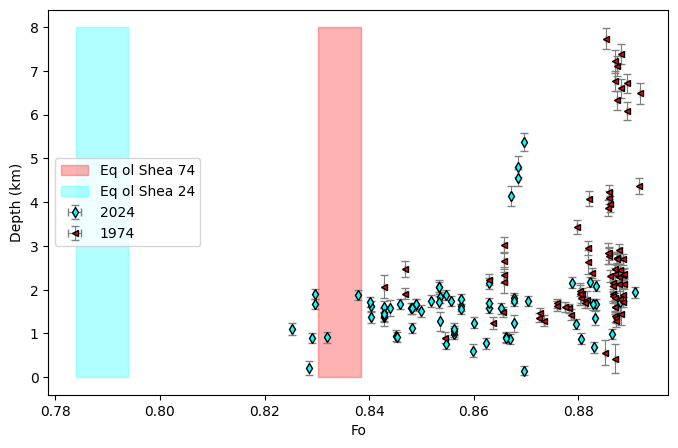

In [134]:
fig, (ax1) = plt.subplots(1, 1, figsize = (8,5))

# Calculate x coordinates
x1 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.345)'])

# Plot rectangle
plt.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='red', alpha=0.3, label='Eq ol Shea 74')

# Calculate x coordinates
x1 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.345)'])

# Plot rectangle
plt.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='cyan', alpha=0.3, label='Eq ol Shea 24')


ax1.errorbar(df_combo['Fo'].loc[K24], MC_Av_rho_T_df_B['SingleCalc_D_km'].loc[K24], xerr=0, yerr=MC_Av_rho_T_df_B['std_dev_MC_D_km_from_percentile'].loc[K24],
             fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', ms=5, mec='k', capsize=3, label='2024')
ax1.errorbar(df_combo['Fo'].loc[U919], MC_Av_rho_T_df_B['SingleCalc_D_km'].loc[U919], xerr=0, yerr=MC_Av_rho_T_df_B['std_dev_MC_D_km_from_percentile'].loc[U919],
             fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', ms=5, mec='k', capsize=3, label='1974')


ax1.set_xlabel('Fo')
ax1.set_ylabel('Depth (km)')
plt.legend()#
fig.savefig('FoDepth.png', dpi=300)

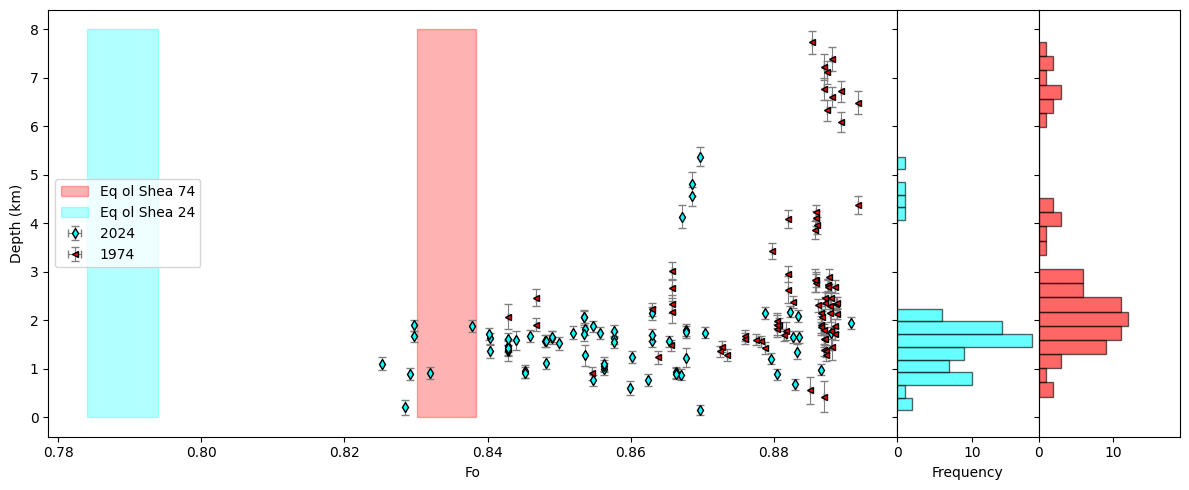

In [135]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 0.5, 0.5], wspace=0)

ax1 = plt.subplot(gs[0])

# Calculate x coordinates and plot rectangles for Eq_Ol_19
x1 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.345)'])
ax1.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='red', alpha=0.3, label='Eq ol Shea 74')

# Calculate x coordinates and plot rectangles for Eq_Ol_24
x1 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.345)'])
ax1.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='cyan', alpha=0.3, label='Eq ol Shea 24')

# Plot error bars
ax1.errorbar(df_combo['Fo'].loc[K24], MC_Av_rho_T_df_B['SingleCalc_D_km'].loc[K24], xerr=0, yerr=MC_Av_rho_T_df_B['std_dev_MC_D_km_from_percentile'].loc[K24],
             fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', ms=5, mec='k', capsize=3, label='2024')
ax1.errorbar(df_combo['Fo'].loc[U919], MC_Av_rho_T_df_B['SingleCalc_D_km'].loc[U919], xerr=0, yerr=MC_Av_rho_T_df_B['std_dev_MC_D_km_from_percentile'].loc[U919],
             fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', ms=5, mec='k', capsize=3, label='1974')

ax1.set_xlabel('Fo')
ax1.set_ylabel('Depth (km)')
ax1.legend()

# Histogram plot
ax2 = plt.subplot(gs[1], sharey=ax1)
ax3 = plt.subplot(gs[2], sharey=ax1, sharex=ax2)
ax2.hist(MC_Av_rho_T_df_B['SingleCalc_D_km'].loc[K24], bins=20, stacked=True, orientation='horizontal', color=['cyan'], ec='k', alpha=0.6)
ax3.hist(MC_Av_rho_T_df_B['SingleCalc_D_km'].loc[U919], bins=25, stacked=True, orientation='horizontal', color=['red'], ec='k', alpha=0.6)

ax2.set_xlabel('Frequency')
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.tight_layout()
fig.savefig('FoDepth.png', dpi=300)
plt.show()

In [136]:
df_merged=pd.merge(left=df_combo,right=MC_Av_rho_T_df_B,left_on='filename_4merge',right_on='Filename',suffixes=('_og', '_pwrecalc'))
# df_merged.to_clipboard(excel=True)

EBSD_tags=pd.read_excel(os.getcwd()+slash+"Combined_EBSD"+slash+"Raman+EDS+EBSDtags.xlsx")

df_wEBSDtags=pd.merge(left=df_merged,right=EBSD_tags,left_on='filename_4merge',right_on='filename_4merge')

df_wEBSDtags.to_clipboard(excel=True)

In [137]:
EBSD_data=pd.read_excel(os.getcwd()+slash+"Combined_EBSD"+slash+"EBSD_combined_all.xlsx")

final_df=pd.merge(left=df_wEBSDtags,left_on='EBSDname+grainID',right=EBSD_data,right_on='EBSDname+grainID',suffixes=('_main', '_EBSDdata'),how='left')

##### Export fully merge data ####

final_df.to_excel("Final_data_wEBSD.xlsx")
final_df

,Mount,filename,filename_4merge,Name_on_SEM,Notes regarding SEM matching,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,...,GB Length/Sqrt Size,Total GB length,Tilt length,Twist length,Perc Tilt,Perc Twist,Perc unclassified,Divangle,Deformed,Day_EBSDdata
0,A,K24_10_FIA,K24_10_FIA_index41,K24_10_FIA,NaN,0.048859,0.004082,0.001386,0.003840,102.873563,...,0.855165,43.797467,4.970789,19.743381,11.349489,45.078820,43.571690,NaN,Uncertain,1.0
1,A,K24_10_FIB,K24_10_FIB_index42,K24_10_FIB,NaN,0.056119,0.004361,0.002092,0.003826,102.891885,...,0.855165,43.797467,4.970789,19.743381,11.349489,45.078820,43.571690,NaN,Uncertain,1.0
2,A,K24_11_FIA,K24_11_FIA_index43,"K24_11_FIA,B",NaN,0.125982,0.004292,0.001919,0.003839,103.068198,...,0.571742,31.336491,19.428579,0.000000,61.999856,0.000000,38.000144,1.0,Uncertain,1.0
3,A,K24_11_FIB,K24_11_FIB_index44,"K24_11_FIA,B",NaN,0.085747,0.012513,0.011921,0.003801,102.966658,...,0.571742,31.336491,19.428579,0.000000,61.999856,0.000000,38.000144,1.0,Uncertain,1.0
4,A,K24_11_FIC,K24_11_FIC_index45,K24_11_FIC,NaN,0.129648,0.004284,0.001886,0.003846,103.077452,...,0.571742,31.336491,19.428579,0.000000,61.999856,0.000000,38.000144,1.0,Uncertain,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,NaN,K24_40_FIA,K24_40_FIA_index166,K24_40_FIA,NaN,0.113685,0.004704,0.002748,0.003818,103.037164,...,28.432711,3334.152137,2833.891884,245.205864,84.995878,7.354369,7.649753,3.0,Y,2.0
145,NaN,K24_40_FIB,K24_40_FIB_index167,K24_40_core,NaN,0.127505,0.004580,0.002494,0.003842,103.072041,...,28.432711,3334.152137,2833.891884,245.205864,84.995878,7.354369,7.649753,3.0,Y,2.0
146,NaN,KL0919-013-A-rep2-6mW,KL0919-013-A-rep2-6mW_index147,KL0919_013_FIA,NaN,0.429251,0.005502,0.004975,0.002350,103.779896,...,31.467342,6118.678800,3334.929043,2314.487686,54.504071,37.826592,7.669337,NaN,Y,1.0
147,NaN,KL0919-013-B-rep2-6mW,KL0919-013-B-rep2-6mW_index148,KL0919_013_FIB,NaN,0.387546,0.003067,0.001973,0.002348,103.686032,...,31.467342,6118.678800,3334.929043,2314.487686,54.504071,37.826592,7.669337,NaN,Y,1.0


In [138]:
xtals=pd.read_excel("Helper_file_4xtalmean.xlsx")
final_df=pd.merge(left=final_df,right=xtals,on="filename_4merge",how="left")
final_df


,Mount,filename,filename_4merge,Name_on_SEM,Notes regarding SEM matching,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,...,Total GB length,Tilt length,Twist length,Perc Tilt,Perc Twist,Perc unclassified,Divangle,Deformed,Day_EBSDdata,Crystal
0,A,K24_10_FIA,K24_10_FIA_index41,K24_10_FIA,NaN,0.048859,0.004082,0.001386,0.003840,102.873563,...,43.797467,4.970789,19.743381,11.349489,45.078820,43.571690,NaN,Uncertain,1.0,K24_10
1,A,K24_10_FIB,K24_10_FIB_index42,K24_10_FIB,NaN,0.056119,0.004361,0.002092,0.003826,102.891885,...,43.797467,4.970789,19.743381,11.349489,45.078820,43.571690,NaN,Uncertain,1.0,K24_10
2,A,K24_11_FIA,K24_11_FIA_index43,"K24_11_FIA,B",NaN,0.125982,0.004292,0.001919,0.003839,103.068198,...,31.336491,19.428579,0.000000,61.999856,0.000000,38.000144,1.0,Uncertain,1.0,K24_11
3,A,K24_11_FIB,K24_11_FIB_index44,"K24_11_FIA,B",NaN,0.085747,0.012513,0.011921,0.003801,102.966658,...,31.336491,19.428579,0.000000,61.999856,0.000000,38.000144,1.0,Uncertain,1.0,K24_11
4,A,K24_11_FIC,K24_11_FIC_index45,K24_11_FIC,NaN,0.129648,0.004284,0.001886,0.003846,103.077452,...,31.336491,19.428579,0.000000,61.999856,0.000000,38.000144,1.0,Uncertain,1.0,K24_11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,NaN,K24_40_FIA,K24_40_FIA_index166,K24_40_FIA,NaN,0.113685,0.004704,0.002748,0.003818,103.037164,...,3334.152137,2833.891884,245.205864,84.995878,7.354369,7.649753,3.0,Y,2.0,K24_40
145,NaN,K24_40_FIB,K24_40_FIB_index167,K24_40_core,NaN,0.127505,0.004580,0.002494,0.003842,103.072041,...,3334.152137,2833.891884,245.205864,84.995878,7.354369,7.649753,3.0,Y,2.0,K24_40
146,NaN,KL0919-013-A-rep2-6mW,KL0919-013-A-rep2-6mW_index147,KL0919_013_FIA,NaN,0.429251,0.005502,0.004975,0.002350,103.779896,...,6118.678800,3334.929043,2314.487686,54.504071,37.826592,7.669337,NaN,Y,1.0,KL0919_13
147,NaN,KL0919-013-B-rep2-6mW,KL0919-013-B-rep2-6mW_index148,KL0919_013_FIB,NaN,0.387546,0.003067,0.001973,0.002348,103.686032,...,6118.678800,3334.929043,2314.487686,54.504071,37.826592,7.669337,NaN,Y,1.0,KL0919_13


In [143]:
grouped = final_df.groupby('Crystal')

# Separate numeric and non-numeric columns
numeric_cols = final_df.select_dtypes(include='number')
non_numeric_cols = final_df.select_dtypes(exclude='number')

# Aggregate numeric columns by mean and standard deviation
numeric_xtal_averaged_mean = grouped[numeric_cols.columns].mean()
numeric_xtal_averaged_std = grouped[numeric_cols.columns].std()

# Take the first instance for non-numeric columns
non_numeric_xtal_averaged = grouped[non_numeric_cols.columns].first()

# Concatenate xtal_averageds and reindex columns to the original order
xtal_averaged = pd.concat([numeric_xtal_averaged_mean, non_numeric_xtal_averaged], axis=1)
xtal_averaged = xtal_averaged.reindex(columns=final_df.columns)

# Add standard deviation columns after reindexing
xtal_averaged = pd.concat([xtal_averaged, numeric_xtal_averaged_std.add_suffix('_std')], axis=1)

# Reset index to get a DataFrame
xtal_averaged = xtal_averaged.reset_index(drop=True)

row_counts = grouped.size().reset_index(name='row_count')

# Add a new column "averaged?" based on the row count
row_counts['averaged?'] = 'No'
row_counts.loc[row_counts['row_count'] > 1, 'averaged?'] = 'Yes'

# Merge the row counts back to the aggregated DataFrame
xtal_averaged = pd.merge(xtal_averaged, row_counts[['Crystal', 'averaged?']], on='Crystal', how='left')

# If there are missing values (groups with a single row), fill them with 'No'
xtal_averaged['averaged?'].fillna('No', inplace=True)

xtal_averaged.to_excel("SWRZ_xtal_averaged.xlsx")

/var/folders/r2/dcn33vbj1x1b46n5mm7vn9bc0000gn/T/ipykernel_4775/3162408695.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  xtal_averaged['averaged?'].fillna('No', inplace=True)


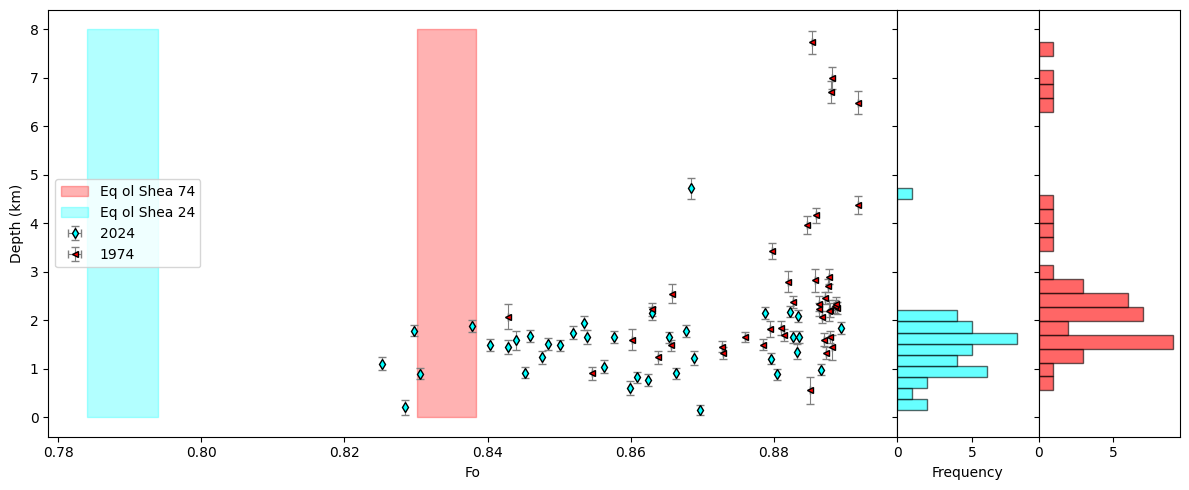

In [144]:
K24=xtal_averaged['filename'].str.contains('K24')
U919=xtal_averaged['filename'].str.contains('919')

# Combine GOS values from both datasets
all_GOS = xtal_averaged['GOS']

# Global min and max of GOS
global_min_GOS = all_GOS.min()
global_max_GOS = all_GOS.max()

# Normalize GOS for marker sizing
normalized_GOS_K24 = (xtal_averaged['GOS'].loc[K24] - global_min_GOS) / (global_max_GOS - global_min_GOS)
normalized_GOS_U919 = (xtal_averaged['GOS'].loc[U919] - global_min_GOS) / (global_max_GOS - global_min_GOS)

# Scale marker sizes (e.g., between 5 and 15)
marker_size_K24 = 5 + 10 * normalized_GOS_K24
marker_size_U919 = 5 + 10 * normalized_GOS_U919

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 0.5, 0.5], wspace=0)

ax1 = plt.subplot(gs[0])

# Calculate x coordinates and plot rectangles for Eq_Ol_19
x1 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.345)'])
ax1.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='red', alpha=0.3, label='Eq ol Shea 74')

# Calculate x coordinates and plot rectangles for Eq_Ol_24
x1 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.345)'])
ax1.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='cyan', alpha=0.3, label='Eq ol Shea 24')

# Plot error bars with marker sizes based on GOS
ax1.errorbar(xtal_averaged['Fo'].loc[K24], xtal_averaged['SingleCalc_D_km'].loc[K24], xerr=0, yerr=xtal_averaged['std_dev_MC_D_km_from_percentile'].loc[K24],
             fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', mec='k', capsize=3, label='2024', ms=5)
ax1.errorbar(xtal_averaged['Fo'].loc[U919], xtal_averaged['SingleCalc_D_km'].loc[U919], xerr=0, yerr=xtal_averaged['std_dev_MC_D_km_from_percentile'].loc[U919],
             fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', mec='k', capsize=3, label='1974', ms=5)

ax1.set_xlabel('Fo')
ax1.set_ylabel('Depth (km)')
ax1.legend()

# Histogram plot
ax2 = plt.subplot(gs[1], sharey=ax1)
ax3 = plt.subplot(gs[2], sharey=ax1, sharex=ax2)
ax2.hist(xtal_averaged['SingleCalc_D_km'].loc[K24], bins=20, stacked=True, orientation='horizontal', color=['cyan'], ec='k', alpha=0.6)
ax3.hist(xtal_averaged['SingleCalc_D_km'].loc[U919], bins=25, stacked=True, orientation='horizontal', color=['red'], ec='k', alpha=0.6)

ax2.set_xlabel('Frequency')
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.tight_layout()
fig.savefig('FoDepth.png', dpi=300)
plt.show()


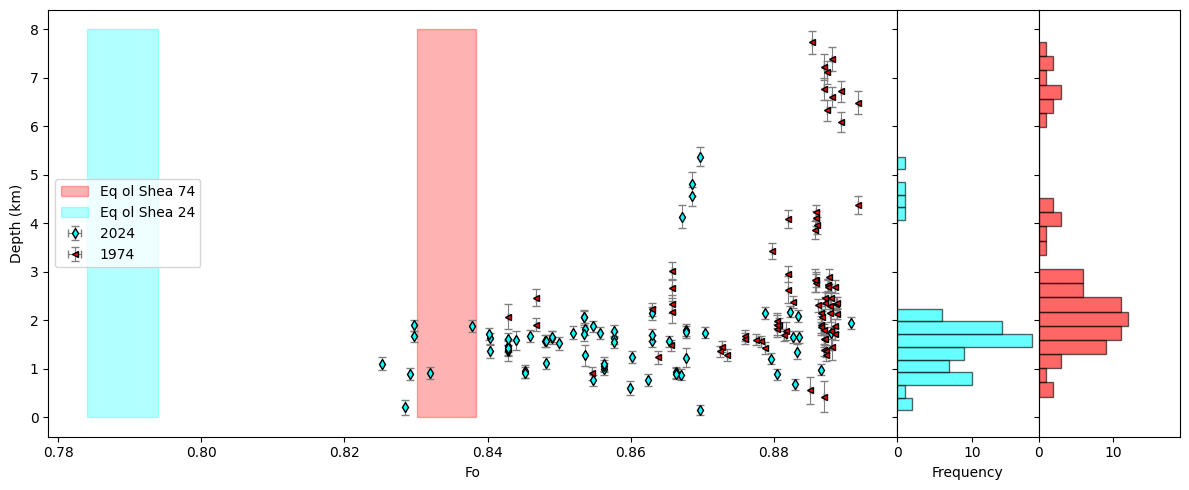

In [140]:
K24=final_df['filename'].str.contains('K24')
U919=final_df['filename'].str.contains('919')

# Combine GOS values from both datasets
all_GOS = final_df['GOS']

# Global min and max of GOS
global_min_GOS = all_GOS.min()
global_max_GOS = all_GOS.max()

# Normalize GOS for marker sizing
normalized_GOS_K24 = (final_df['GOS'].loc[K24] - global_min_GOS) / (global_max_GOS - global_min_GOS)
normalized_GOS_U919 = (final_df['GOS'].loc[U919] - global_min_GOS) / (global_max_GOS - global_min_GOS)

# Scale marker sizes (e.g., between 5 and 15)
marker_size_K24 = 5 + 10 * normalized_GOS_K24
marker_size_U919 = 5 + 10 * normalized_GOS_U919

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 0.5, 0.5], wspace=0)

ax1 = plt.subplot(gs[0])

# Calculate x coordinates and plot rectangles for Eq_Ol_19
x1 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.345)'])
ax1.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='red', alpha=0.3, label='Eq ol Shea 74')

# Calculate x coordinates and plot rectangles for Eq_Ol_24
x1 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.345)'])
ax1.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='cyan', alpha=0.3, label='Eq ol Shea 24')

# Plot error bars with marker sizes based on GOS
ax1.errorbar(final_df['Fo'].loc[K24], final_df['SingleCalc_D_km'].loc[K24], xerr=0, yerr=final_df['std_dev_MC_D_km_from_percentile'].loc[K24],
             fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', mec='k', capsize=3, label='2024', ms=5)
ax1.errorbar(final_df['Fo'].loc[U919], final_df['SingleCalc_D_km'].loc[U919], xerr=0, yerr=final_df['std_dev_MC_D_km_from_percentile'].loc[U919],
             fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', mec='k', capsize=3, label='1974', ms=5)

ax1.set_xlabel('Fo')
ax1.set_ylabel('Depth (km)')
ax1.legend()

# Histogram plot
ax2 = plt.subplot(gs[1], sharey=ax1)
ax3 = plt.subplot(gs[2], sharey=ax1, sharex=ax2)
ax2.hist(final_df['SingleCalc_D_km'].loc[K24], bins=20, stacked=True, orientation='horizontal', color=['cyan'], ec='k', alpha=0.6)
ax3.hist(final_df['SingleCalc_D_km'].loc[U919], bins=25, stacked=True, orientation='horizontal', color=['red'], ec='k', alpha=0.6)

ax2.set_xlabel('Frequency')
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.tight_layout()
fig.savefig('FoDepth.png', dpi=300)
plt.show()


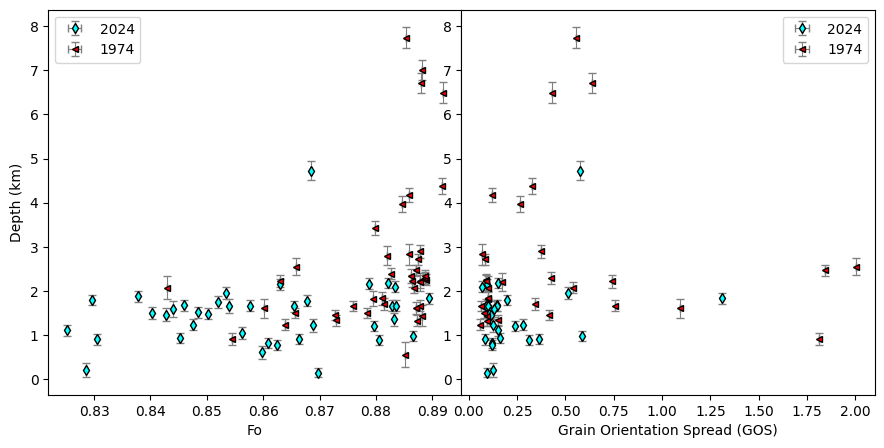

In [145]:
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 0.5], wspace=0)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.errorbar(xtal_averaged['Fo'].loc[K24], xtal_averaged['SingleCalc_D_km'].loc[K24], xerr=0, yerr=xtal_averaged['std_dev_MC_D_km_from_percentile'].loc[K24],
             fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', mec='k', capsize=3, label='2024', ms=5)
ax1.errorbar(xtal_averaged['Fo'].loc[U919], xtal_averaged['SingleCalc_D_km'].loc[U919], xerr=0, yerr=xtal_averaged['std_dev_MC_D_km_from_percentile'].loc[U919],
             fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', mec='k', capsize=3, label='1974', ms=5)

ax1.set_xlabel('Fo')
ax1.set_ylabel('Depth (km)')
ax1.legend()

ax2.errorbar(xtal_averaged['GOS'].loc[K24], xtal_averaged['SingleCalc_D_km'].loc[K24], xerr=0, yerr=xtal_averaged['std_dev_MC_D_km_from_percentile'].loc[K24],
             fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', mec='k', capsize=3, label='2024', ms=5)
ax2.errorbar(xtal_averaged['GOS'].loc[U919], xtal_averaged['SingleCalc_D_km'].loc[U919], xerr=0, yerr=xtal_averaged['std_dev_MC_D_km_from_percentile'].loc[U919],
             fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', mec='k', capsize=3, label='1974', ms=5)

ax2.set_xlabel('Grain Orientation Spread (GOS)')

ax2.legend()

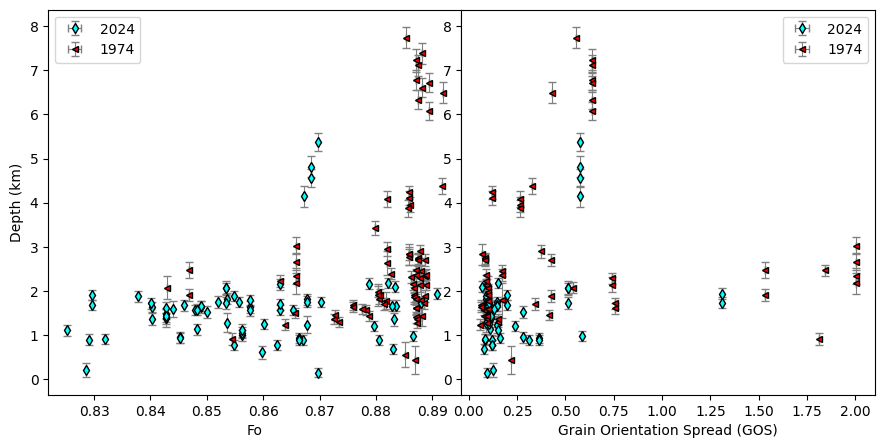

In [77]:
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 0.5], wspace=0)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.errorbar(final_df['Fo'].loc[K24], final_df['SingleCalc_D_km'].loc[K24], xerr=0, yerr=final_df['std_dev_MC_D_km_from_percentile'].loc[K24],
             fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', mec='k', capsize=3, label='2024', ms=5)
ax1.errorbar(final_df['Fo'].loc[U919], final_df['SingleCalc_D_km'].loc[U919], xerr=0, yerr=final_df['std_dev_MC_D_km_from_percentile'].loc[U919],
             fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', mec='k', capsize=3, label='1974', ms=5)

ax1.set_xlabel('Fo')
ax1.set_ylabel('Depth (km)')
ax1.legend()

ax2.errorbar(final_df['GOS'].loc[K24], final_df['SingleCalc_D_km'].loc[K24], xerr=0, yerr=final_df['std_dev_MC_D_km_from_percentile'].loc[K24],
             fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', mec='k', capsize=3, label='2024', ms=5)
ax2.errorbar(final_df['GOS'].loc[U919], final_df['SingleCalc_D_km'].loc[U919], xerr=0, yerr=final_df['std_dev_MC_D_km_from_percentile'].loc[U919],
             fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', mec='k', capsize=3, label='1974', ms=5)

ax2.set_xlabel('Grain Orientation Spread (GOS)')

ax2.legend()

In [78]:
final_df[K24][final_df['GOS']>1.2]

/var/folders/r2/dcn33vbj1x1b46n5mm7vn9bc0000gn/T/ipykernel_4775/1322677967.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_df[K24][final_df['GOS']>1.2]


,Mount,filename,filename_4merge,Name_on_SEM,Notes regarding SEM matching,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,...,GB Length/Sqrt Size,Total GB length,Tilt length,Twist length,Perc Tilt,Perc Twist,Perc unclassified,Divangle,Deformed,Day_EBSDdata
144,NaN,K24_40_FIA,K24_40_FIA_index166,K24_40_FIA,NaN,0.113685,0.004704,0.002748,0.003818,103.037164,...,28.432711,3334.152137,2833.891884,245.205864,84.995878,7.354369,7.649753,3.0,Y,2.0
145,NaN,K24_40_FIB,K24_40_FIB_index167,K24_40_core,NaN,0.127505,0.004580,0.002494,0.003842,103.072041,...,28.432711,3334.152137,2833.891884,245.205864,84.995878,7.354369,7.649753,3.0,Y,2.0


Text(0, 0.5, 'Cumulative probability')

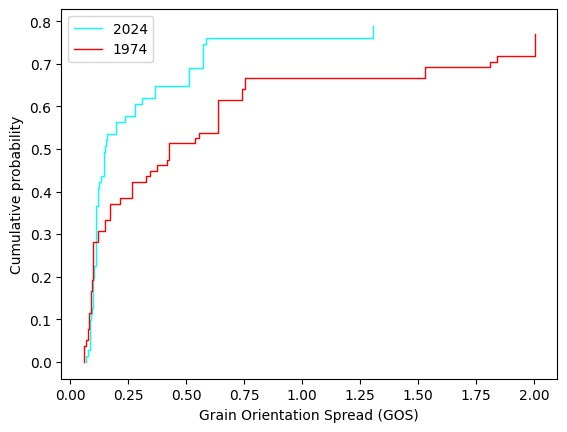

In [79]:
x1=final_df['GOS'][K24]

x1_sorted=np.sort(x1)

plt.step(np.concatenate([x1_sorted, x1_sorted[[-1]]]),

np.arange(x1_sorted.size+1)/x1_sorted.size, color='cyan', linewidth=1, label="2024")

x1=final_df['GOS'][U919]

x1_sorted=np.sort(x1)

plt.step(np.concatenate([x1_sorted, x1_sorted[[-1]]]),

np.arange(x1_sorted.size+1)/x1_sorted.size, color='red', linewidth=1, label="1974")
plt.legend()
plt.xlabel('Grain Orientation Spread (GOS)')
plt.ylabel('Cumulative probability')


Text(0.5, 0, 'Fo')

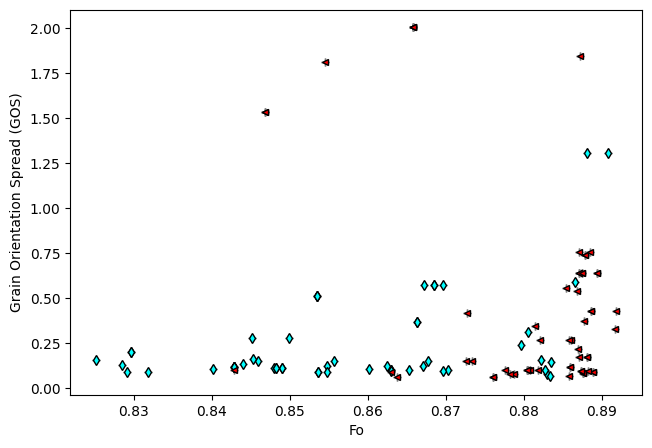

In [80]:
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[4, 2, 0.5], wspace=0)

ax1 = plt.subplot(gs[0])

ax1.errorbar(final_df['Fo'].loc[K24], final_df['GOS'].loc[K24], xerr=0, yerr=0,
             fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', mec='k', capsize=3, label='2024', ms=5)
ax1.errorbar(final_df['Fo'].loc[U919],final_df['GOS'].loc[U919],  xerr=0, yerr=0,
             fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', mec='k', capsize=3, label='1974', ms=5)

ax1.set_ylabel('Grain Orientation Spread (GOS)')
ax1.set_xlabel('Fo')


In [82]:
final_df[final_df['GOS']>0.6][['filename','GOS','SingleCalc_D_km']]

,filename,GOS,SingleCalc_D_km
43,KL0919-001-A-rep1,2.003487,2.170643
44,KL0919-001-A-rep2,2.003487,2.337327
45,KL0919-001-B-rep1,2.003487,2.661424
46,KL0919-001-B-rep2,2.003487,3.025638
54,919_50_FIA,0.740952,2.141565
55,919_50_FIB,0.740952,2.286365
79,KL0919-007-A,1.841022,2.464134
88,KL0919-012-E,1.531582,1.911969
89,KL0919-012-F,1.531582,2.466727
90,KL0919-013-A,0.635922,6.771967


In [54]:
final_df[final_df['SingleCalc_D_km']>4][['filename','GOS','SingleCalc_D_km']]

,filename,GOS,SingleCalc_D_km
80,KL0919-008-A,0.554341,7.737790
90,KL0919-013-A,0.635922,6.771967
91,KL0919-013-B,0.635922,7.111117
92,KL0919-013-C,0.635922,6.719386
110,919_56_A,0.118908,4.229915
111,919_56_A_drift,0.118908,4.106109
112,919_58_A,0.266591,4.084473
116,919_60_A,0.428472,6.489178
122,919_65_A_rep1_12mW,NaN,6.605082
123,919_65_A_rep2_6mW,NaN,7.388014


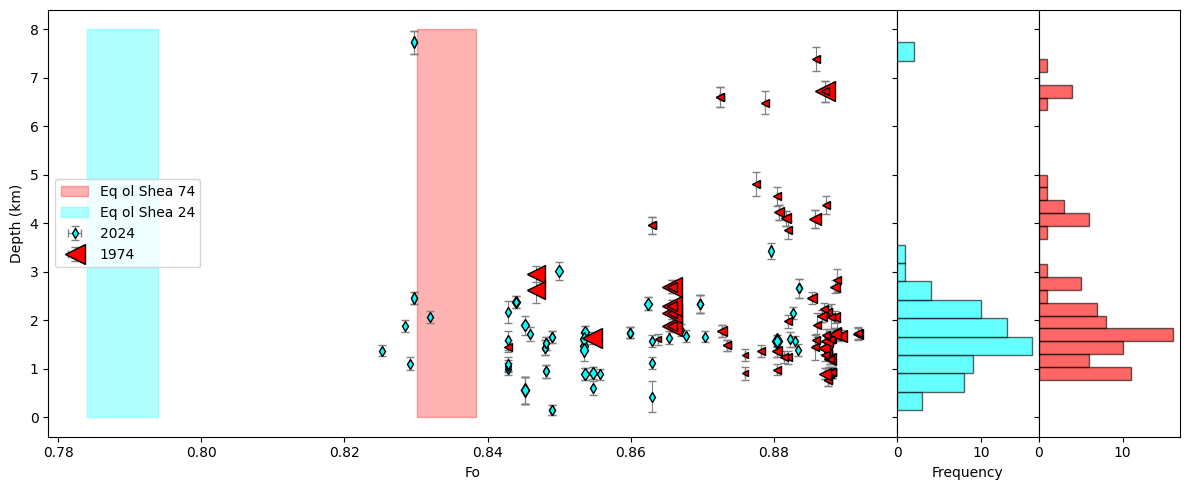

In [47]:
# Combine GOS values from both datasets
all_GOS = final_df['GOS']

# Global min and max of GOS
global_min_GOS = all_GOS.min()
global_max_GOS = all_GOS.max()

# Normalize GOS for marker sizing
normalized_GOS_K24 = (final_df['GOS'].loc[K24] - global_min_GOS) / (global_max_GOS - global_min_GOS)
normalized_GOS_U919 = (final_df['GOS'].loc[U919] - global_min_GOS) / (global_max_GOS - global_min_GOS)

# Scale marker sizes (e.g., between 5 and 15)
marker_size_K24 = 5 + 10 * normalized_GOS_K24
marker_size_U919 = 5 + 10 * normalized_GOS_U919

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 0.5, 0.5], wspace=0)

ax1 = plt.subplot(gs[0])

# Calculate x coordinates and plot rectangles for Eq_Ol_19
x1 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_19['Eq Fo (Shea, Kd=0.345)'])
ax1.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='red', alpha=0.3, label='Eq ol Shea 74')

# Calculate x coordinates and plot rectangles for Eq_Ol_24
x1 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.325)'])
x2 = np.mean(Eq_Ol_24['Eq Fo (Shea, Kd=0.345)'])
ax1.fill_betweenx(y=[0, 8], x1=x1, x2=x2, color='cyan', alpha=0.3, label='Eq ol Shea 24')

# Plot error bars with marker sizes based on GOS
for i, (fo, depth, yerr, size) in enumerate(zip(final_df['Fo'].loc[K24], final_df['SingleCalc_D_km_pwrecalc'].loc[K24], final_df['std_dev_MC_D_km_from_percentile_pwrecalc'].loc[K24], marker_size_K24)):
    ax1.errorbar(fo, depth, xerr=0, yerr=yerr, fmt='d', ecolor='grey', elinewidth=0.8, mfc='cyan', mec='k', capsize=3, label='2024' if i == 0 else "", ms=size)

for i, (fo, depth, yerr, size) in enumerate(zip(final_df['Fo'].loc[U919], final_df['SingleCalc_D_km_pwrecalc'].loc[U919], final_df['std_dev_MC_D_km_from_percentile_pwrecalc'].loc[U919], marker_size_U919)):
    ax1.errorbar(fo, depth, xerr=0, yerr=yerr, fmt='<', ecolor='grey', elinewidth=0.8, mfc='red', mec='k', capsize=3, label='1974' if i == 0 else "", ms=size)

ax1.set_xlabel('Fo')
ax1.set_ylabel('Depth (km)')
ax1.legend()

# Histogram plot
ax2 = plt.subplot(gs[1], sharey=ax1)
ax3 = plt.subplot(gs[2], sharey=ax1, sharex=ax2)
ax2.hist(final_df['SingleCalc_D_km_pwrecalc'].loc[K24], bins=20, stacked=True, orientation='horizontal', color=['cyan'], ec='k', alpha=0.6)
ax3.hist(final_df['SingleCalc_D_km_pwrecalc'].loc[U919], bins=25, stacked=True, orientation='horizontal', color=['red'], ec='k', alpha=0.6)

ax2.set_xlabel('Frequency')
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.tight_layout()
fig.savefig('FoDepth.png', dpi=300)
plt.show()


#### Below this are tests ###

/var/folders/r2/dcn33vbj1x1b46n5mm7vn9bc0000gn/T/ipykernel_4775/2130890076.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


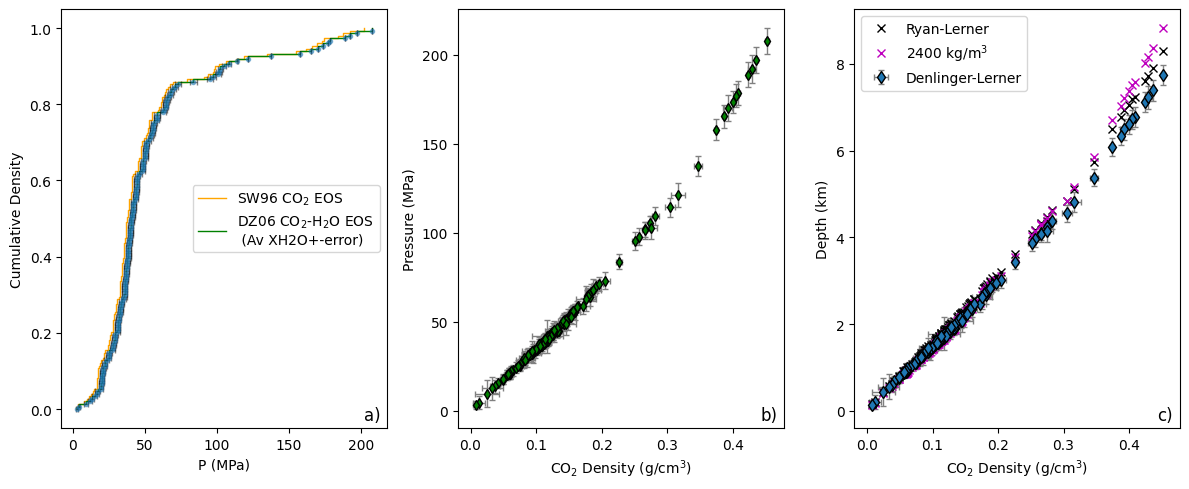

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))


## LETS SHOW A CDF FUNCTION OF THE PRESSURE DIFFERENCE - ITS SMALL ############

x1=100*P_DZ062['P_kbar_pureCO2_SW96']
x1_sorted=np.sort(x1)
ax1.step(np.concatenate([x1_sorted, x1_sorted[[-1]]]),
         np.arange(x1_sorted.size+1)/x1_sorted.size, color='orange', linewidth=1, label='SW96 CO$_2$ EOS')

x1=100*P_DZ062['P_kbar_mixCO2_DZ06_Hloss']
x1_sorted=np.sort(x1)
ax1.step(np.concatenate([x1_sorted, x1_sorted[[-1]]]),
         np.arange(x1_sorted.size+1)/x1_sorted.size, color='green', linewidth=1, label='DZ06 CO$_2$-H$_2$O EOS \n (Av XH2O+-error)')
plt.legend()

x2=100*P_DZ06_MinXH2O2['P_kbar_mixCO2_DZ06_Hloss']
x2_sorted=np.sort(x2)
# ax1.step(np.concatenate([x2_sorted, x2_sorted[[-1]]]),
#          np.arange(x2_sorted.size+1)/x2_sorted.size, color='red', linewidth=1, linestyle='-', label='DZ06')
y = np.arange(x1_sorted.size + 1) / x1_sorted.size  # Cumulative probability for each step


x3=100*P_DZ06_MaxXH2O2['P_kbar_mixCO2_DZ06_Hloss']
x3_sorted=np.sort(x3)
# ax1.step(np.concatenate([x3_sorted, x3_sorted[[-1]]]),
#          np.arange(x3_sorted.size+1)/x3_sorted.size, color='blue', linewidth=1, linestyle='-', label='DZ06')
ax1.legend()
ax1.set_xlabel('P (MPa)')
ax1.set_ylabel('Cumulative Density')


error = np.full_like(x1_sorted, 5)  # Replace 5 with your actual error values

# Adding horizontal error bars - notice 'fmt='none'' for no central marker, adjust 'ecolor' and 'elinewidth' as needed
ax1.errorbar(x1_sorted, y[:-1], xerr=[x3_sorted-x1_sorted, x1_sorted-x2_sorted], fmt='o', ms=3, ecolor='k', capsize=2, elinewidth=1, alpha=0.5)


ax2.plot()

ax2.errorbar(df_combo['Density g/cm3'], 100*MC_Av_rho_T_df_B['SingleCalc_P_kbar'], 
             xerr=df_combo['σ Density g/cm3'], yerr=100*MC_Av_rho_T_df_B['std_dev_MC_P_kbar_from_percentile'],
               fmt='d', mec='k',ecolor='grey', mfc='green', ms=5, capsize=2, elinewidth=1, alpha=1)

ax2.set_xlabel('CO$_2$ Density (g/cm$^{3}$)')
ax2.set_ylabel('Pressure (MPa)')


# Lets show different density-depth models

Depth_RL=pf.convert_pressure_to_depth(P_kbar=P_DZ062['P_kbar_mixCO2_DZ06_Hloss'], model='ryan_lerner')
Depth_2400=pf.convert_pressure_to_depth(P_kbar=P_DZ062['P_kbar_mixCO2_DZ06_Hloss'], crust_dens_kgm3=2400)

ax3.errorbar(df_combo['Density g/cm3'], MC_Av_rho_T_df_B['SingleCalc_D_km'], 
             xerr=df_combo['σ Density g/cm3'], yerr=MC_Av_rho_T_df_B['std_dev_MC_D_km_from_percentile'],
               fmt='d', mec='k',  ecolor='grey', capsize=2, elinewidth=1, alpha=1, label='Denlinger-Lerner')

ax3.plot(df_combo['Density g/cm3'], Depth_RL, 'xk', label='Ryan-Lerner')
ax3.plot(df_combo['Density g/cm3'], Depth_2400, 'xm', label='2400 kg/m$^{3}$')
ax3.set_xlabel('CO$_2$ Density (g/cm$^{3}$)')
ax3.set_ylabel('Depth (km)')
ax3.legend()
fig.tight_layout()

ax1.annotate("a)", xy=(0.93, 0.02), xycoords="axes fraction", fontsize=12)
ax2.annotate("b)", xy=(0.93, 0.02), xycoords="axes fraction", fontsize=12)
ax3.annotate("c)", xy=(0.93, 0.02), xycoords="axes fraction", fontsize=12)
fig.savefig('Errors_2022FI.png', dpi=200)